# Home Credit Default Risk
This notebook is based on the above named kaggle competition. <br>
The goal of this competition is predicting credit defaults based on a large number of variables. <br>

As shown in the graphic below, the available data consinst of a main dataset and multiple supplementary datasets which are connected through either a unique credit or client ID. <br>
<br>

![title](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

My personal goal is to achieve a ROC score of at least 0.8, which would have been enough to place among the winners of this competition in 2018.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix
import lightgbm as lgb

### Main dataset
The main dataset contains a unique credit identifiers SK_ID_CURR, 120 independent variables and a target variable indicating if the debtor defaulted on the credit.

In [2]:
df = pd.read_csv('./home-credit-default-risk/application_train.csv')
print(len(df))
df.head()

307511


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### Taking a look at a few variables
I examine a few of the variables, to check if are any potential problems.

#### Target
In this Kaggle competition, we try to predict if clients will default on a given loan. <br>
Less than 10% of all observed loans default, for this reason ROC AUC is used as the competition metric instead of accuracy.

<AxesSubplot:xlabel='TARGET', ylabel='count'>

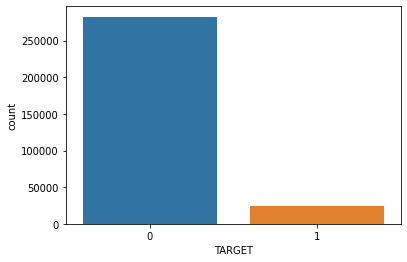

In [3]:
sns.countplot(x=df.TARGET)

#### Length of Employment
The distribution of days in employment looks off. There is a large number of clients with a reported length of employment of -1000 years. It is probably a flag of some sort. <br>
I replace these values with nan and add an additional flag. <br>
The distribution looks reasonable after this step, with a minimum of 0 years (unemployed) and a maximum of 49 years.

In [4]:
(df.DAYS_EMPLOYED / -365).describe()

count    307511.000000
mean       -174.835742
std         387.056895
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

In [5]:
df.loc[(df.DAYS_EMPLOYED / -365) < 0, 'DAYS_EMPLOYED'].value_counts()

365243    55374
Name: DAYS_EMPLOYED, dtype: int64

In [6]:
df['DAYS_EMPLOYED_flagged'] = df["DAYS_EMPLOYED"] == 365243
df.loc[df.DAYS_EMPLOYED_flagged == True, 'DAYS_EMPLOYED'] = np.nan

In [7]:
(df.DAYS_EMPLOYED / -365).describe()

count    252137.000000
mean          6.531971
std           6.406466
min          -0.000000
25%           2.101370
50%           4.515068
75%           8.698630
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

### Feature engineering
I construct three new features which might be useful to predict default risk. <br>
First the ratios of credit sum to income and yearly annuity to income and secondly the length of the credit contract, calculated as the annuity divided by the credit sum.

In [8]:
df['income_pct'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['income_pct'].describe().round(2)

count    307511.00
mean          3.96
std           2.69
min           0.00
25%           2.02
50%           3.27
75%           5.16
max          84.74
Name: income_pct, dtype: float64

In [9]:
df['annuity_pct'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['annuity_pct'].describe().round(2)

count    307499.00
mean          0.18
std           0.09
min           0.00
25%           0.11
50%           0.16
75%           0.23
max           1.88
Name: annuity_pct, dtype: float64

In [10]:
df['credit_term'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
df['credit_term'].describe().round(2)

count    307499.00
mean          0.05
std           0.02
min           0.02
25%           0.04
50%           0.05
75%           0.06
max           0.12
Name: credit_term, dtype: float64

#### Preprocessing data
I use FastAIs TabularDataLoaders class to simplify all steps of data preprocessing. <br>
Categorical features are ordinal encoded, missing values are filled in as 0 and a *missing* flag is added and continuous variables are normalized.
Finally, the dataset is separated into training and validation sets.

In [11]:
cont_names, cat_names = cont_cat_split(df, dep_var='TARGET')

procs = [Categorify, FillMissing, Normalize]
dls = TabularDataLoaders.from_df(df, procs=procs, cat_names=cat_names, cont_names=cont_names, y_names='TARGET', y_block=CategoryBlock, bs=512)
dls.show_batch()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,DAYS_EMPLOYED_flagged,AMT_ANNUITY_na,AMT_GOODS_PRICE_na,DAYS_EMPLOYED_na,OWN_CAR_AGE_na,CNT_FAM_MEMBERS_na,EXT_SOURCE_1_na,EXT_SOURCE_2_na,EXT_SOURCE_3_na,APARTMENTS_AVG_na,BASEMENTAREA_AVG_na,YEARS_BEGINEXPLUATATION_AVG_na,YEARS_BUILD_AVG_na,COMMONAREA_AVG_na,ELEVATORS_AVG_na,ENTRANCES_AVG_na,FLOORSMAX_AVG_na,FLOORSMIN_AVG_na,LANDAREA_AVG_na,LIVINGAPARTMENTS_AVG_na,LIVINGAREA_AVG_na,NONLIVINGAPARTMENTS_AVG_na,NONLIVINGAREA_AVG_na,APARTMENTS_MODE_na,BASEMENTAREA_MODE_na,YEARS_BEGINEXPLUATATION_MODE_na,YEARS_BUILD_MODE_na,COMMONAREA_MODE_na,ELEVATORS_MODE_na,ENTRANCES_MODE_na,FLOORSMAX_MODE_na,FLOORSMIN_MODE_na,LANDAREA_MODE_na,LIVINGAPARTMENTS_MODE_na,LIVINGAREA_MODE_na,NONLIVINGAPARTMENTS_MODE_na,NONLIVINGAREA_MODE_na,APARTMENTS_MEDI_na,BASEMENTAREA_MEDI_na,YEARS_BEGINEXPLUATATION_MEDI_na,YEARS_BUILD_MEDI_na,COMMONAREA_MEDI_na,ELEVATORS_MEDI_na,ENTRANCES_MEDI_na,FLOORSMAX_MEDI_na,FLOORSMIN_MEDI_na,LANDAREA_MEDI_na,LIVINGAPARTMENTS_MEDI_na,LIVINGAREA_MEDI_na,NONLIVINGAPARTMENTS_MEDI_na,NONLIVINGAREA_MEDI_na,TOTALAREA_MODE_na,OBS_30_CNT_SOCIAL_CIRCLE_na,DEF_30_CNT_SOCIAL_CIRCLE_na,OBS_60_CNT_SOCIAL_CIRCLE_na,DEF_60_CNT_SOCIAL_CIRCLE_na,DAYS_LAST_PHONE_CHANGE_na,AMT_REQ_CREDIT_BUREAU_HOUR_na,AMT_REQ_CREDIT_BUREAU_DAY_na,AMT_REQ_CREDIT_BUREAU_WEEK_na,AMT_REQ_CREDIT_BUREAU_MON_na,AMT_REQ_CREDIT_BUREAU_QRT_na,AMT_REQ_CREDIT_BUREAU_YEAR_na,annuity_pct_na,credit_term_na,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,income_pct,annuity_pct,credit_term,TARGET
0,Cash loans,F,N,Y,1,Unaccompanied,Working,Secondary / secondary special,Single / not married,With parents,1,1,0,1,1,0,Waiters/barmen staff,2,2,THURSDAY,0,0,0,0,1,1,Self-employed,#na#,#na#,#na#,#na#,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,False,False,True,False,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,T

## Running a few quick models
To get a baseline, I run three simple models on the main dataset.

### Random Forest
I start of with a simple Random Forest. This model achieves a ROC of 0.7245, which doesnt sound too bad. <br>
But the confusion matrix shows that the model performs very badly in terms of detecting defaults. While there are only 2 false positives, the model only picks up on 4 (out of thousands) defaulted loans.

In [12]:
rf = RandomForestClassifier(n_estimators = 200, random_state = 42, verbose = 1, n_jobs = -1)

In [13]:
rf.fit(dls.train.xs, dls.train.y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   24.0s finished


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42, verbose=1)

In [14]:
roc_auc_score(dls.valid.y, rf.predict_proba(dls.valid.xs)[:, 1])

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.4s finished


0.7245068551892085

In [15]:
def print_confusion(model, dls):
    pred = model.predict(dls.valid.xs)
    cm = confusion_matrix(dls.valid.y, pred)
    
    cm_matrix = pd.DataFrame(data=cm, columns=['Actual No Default', 'Actual Default'], 
                                 index=['Predict No Default', 'Predict Default'])
    
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.4s finished


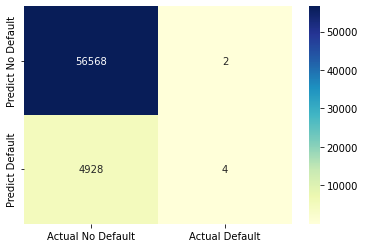

In [16]:
print_confusion(rf, dls)

### Neural net
A very basic neural net with two hidden layers performs a bit better with a ROC of 0.7506. <br>
Compared to the Random Forest, the amount of true positives improves to 160, at the cost of 221 false negatives. This result is still very underwhelming.

In [17]:
learn = tabular_learner(dls, metrics=[RocAucBinary()])

SuggestedLRs(valley=0.0012022644514217973)

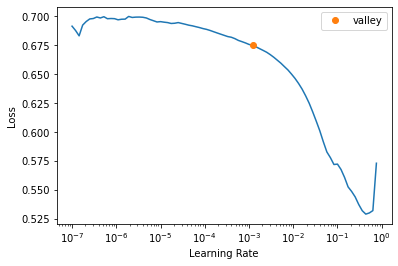

In [18]:
learn.lr_find()

In [19]:
learn.fit(5, 0.001)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.256923,0.250422,0.742834,00:09
1,0.247413,0.250365,0.745660,00:09
2,0.247156,0.248444,0.748940,00:08
3,0.244068,0.248717,0.750564,00:08
4,0.247807,0.249591,0.748671,00:08


In [20]:
def print_confusion_nn(learner):
    pred, targ = learn.get_preds(dl=dls.valid)
    pred = np.arange(pred.shape[1])[np.argmax(pred, axis=1)]
    
    cm = confusion_matrix(targ, pred)
    
    cm_matrix = pd.DataFrame(data=cm, columns=['Actual No Default', 'Actual Default'], 
                            index=['Predict No Default', 'Predict Default'])
    
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

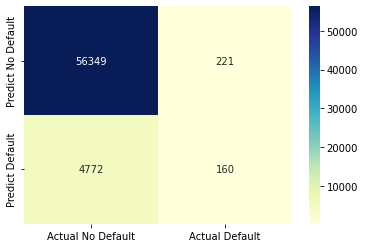

In [21]:
print_confusion_nn(learn)

### Gradient boosting
Basically all top entries in the competition use boosted random forests. <br>
Unsurprisingly, I get the best result so far (0.7630) when using LightGBM as well. More importantly, this model actually works a lot better at predicting defaults. 3284 defaults are correctly classified. <br>
The model still needs a lot of work however, since there are still 15625 false negatives and 1648 false positives.

In [22]:
model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', class_weight = 'balanced', 
                           learning_rate = 0.05, reg_alpha = 0.1, reg_lambda = 0.1, 
                           subsample = 0.8, n_jobs = -1, random_state = 42)

In [23]:
def fit_lgb(model, dls):
    valid_features =  np.array(dls.valid.xs)
    valid_labels = np.array(dls.valid.y)
    train_features =  np.array(dls.train.xs)
    train_labels = np.array(dls.train.y)
    cat_indices = [dls.valid.xs.columns.get_loc(col) for col in cat_names]
    
    model.fit(train_features, train_labels, eval_metric = 'auc',
          eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
          eval_names = ['valid', 'train'], categorical_feature = cat_indices,
          callbacks = [lgb.early_stopping(100), lgb.log_evaluation(100)])
    
    
def print_confusion(model, dls):
    valid_features =  np.array(dls.valid.xs)
    valid_labels = np.array(dls.valid.y)
    
    pred = model.predict(valid_features)
    cm = confusion_matrix(valid_labels, pred)
    
    cm_matrix = pd.DataFrame(data=cm, columns=['Actual No Default', 'Actual Default'], 
                                 index=['Predict No Default', 'Predict Default'])
    
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [24]:
fit_lgb(model, dls)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Ove

Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.788308	train's binary_logloss: 0.560656	valid's auc: 0.759006	valid's binary_logloss: 0.572255
[200]	train's auc: 0.812558	train's binary_logloss: 0.534489	valid's auc: 0.762893	valid's binary_logloss: 0.555142
[300]	train's auc: 0.829828	train's binary_logloss: 0.516587	valid's auc: 0.762562	valid's binary_logloss: 0.544217
Early stopping, best iteration is:
[241]	train's auc: 0.819869	train's binary_logloss: 0.526883	valid's auc: 0.763016	valid's binary_logloss: 0.550551


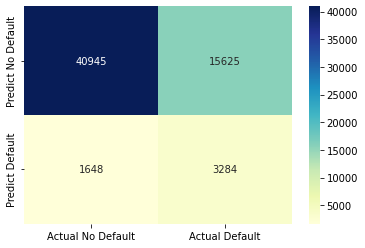

In [25]:
print_confusion(model, dls)

### Feature importance
This might be a good moment to take a look at the feature importance. <br>
I am happy to see that all three of my constructed variables seem to be pretty important. <br>
The clients employer seems to be extremely important, which I didnt expect.

In [26]:
def plot_feature_imp(dls, model):
    feature_imp = pd.DataFrame(sorted(zip(dls.xs.columns,model.feature_importances_)), columns=['Feature', 'Importance'])

    plt.figure(figsize=(20, 10))
    sns.barplot(x='Importance', y='Feature', data=feature_imp.sort_values(by='Importance', ascending=False)[0:20])
    plt.title('LightGBM Feature Importance')
    plt.tight_layout()
    plt.show()

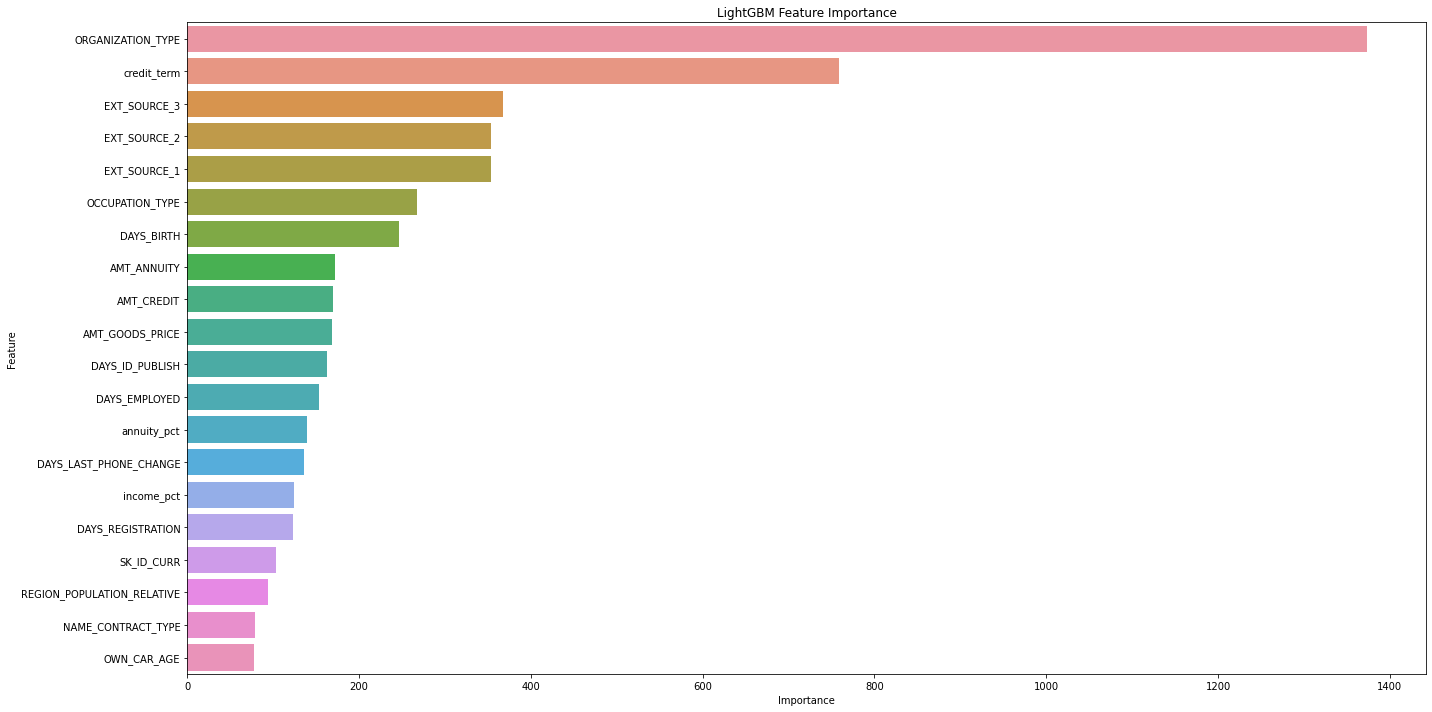

In [27]:
plot_feature_imp(dls, model)

#### Closer look at organization types
I take a closer look at the default rates for different organization types. <br>
The highest default rates are found in insecure, seasonal and low paid sectors like restaurants, construction, cleaning or farming. On the other hand, clients that work for the government, for example at universities, the police or military or schools have significantly lower default rates.

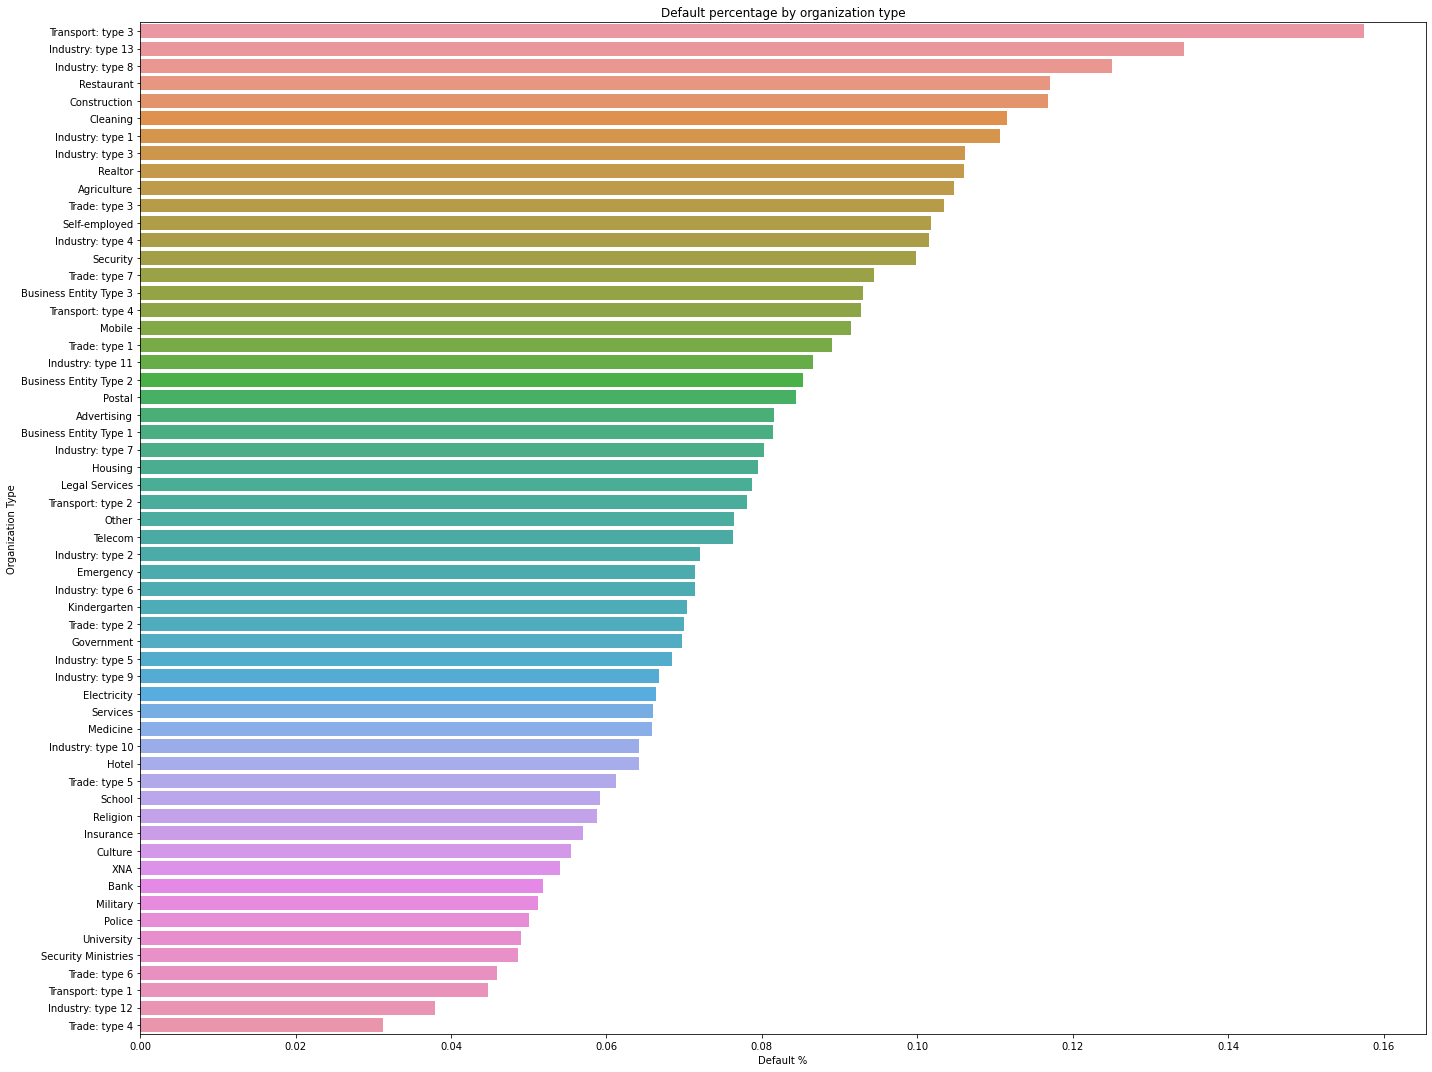

In [28]:
organization_types = df.ORGANIZATION_TYPE.value_counts().index.values
organization_types_default = []
for i in organization_types:
    pct = len(df[(df.ORGANIZATION_TYPE == i) & (df.TARGET == 1)]) / len(df[df.ORGANIZATION_TYPE == i])
    organization_types_default.append(pct)
    
organization_types = pd.DataFrame(zip(organization_types, organization_types_default), columns=['Organization Type', 'Default %'])

plt.figure(figsize=(20, 15))
sns.barplot(x='Default %', y='Organization Type', data=organization_types.sort_values(by='Default %', ascending=False))
plt.title('Default percentage by organization type')
plt.tight_layout()
plt.show()

#### Closer look at external source
The three external sources are all very important. I suspect them to be some sort of credit rating. <br>
The KDE plots show a significantly higher chance of default for lower values of these features.

In [29]:
def kdeplot(var):
    plt.figure(figsize = (12, 6))
    
    sns.kdeplot(df.loc[df['TARGET'] == 0, var], label = 'No Default')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var], label = 'Default')
    
    plt.xlabel(var); plt.ylabel('Density'); plt.title('{} Distribution'.format(var))
    plt.legend();

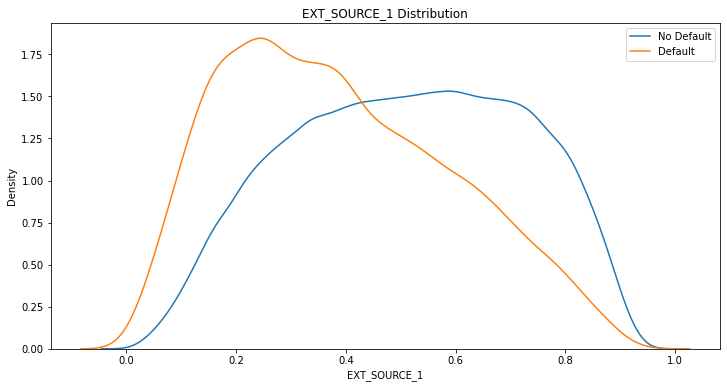

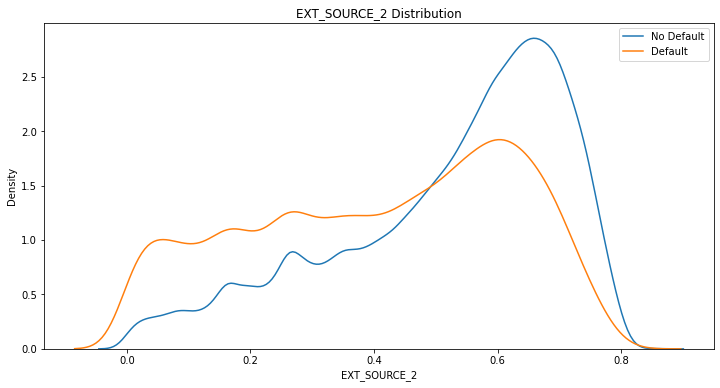

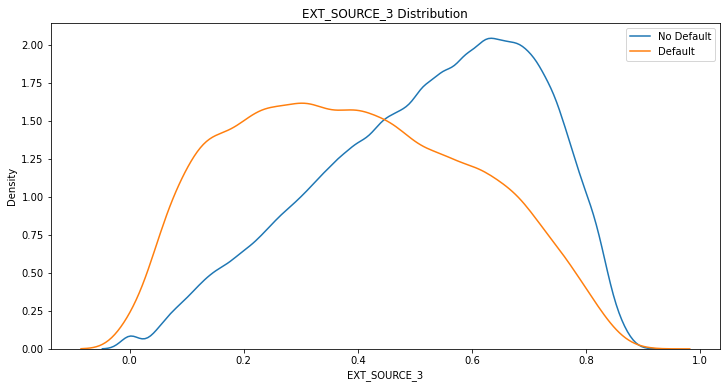

In [30]:
for i in range(1,4):
    kdeplot('EXT_SOURCE_{}'.format(i))